<a href="https://colab.research.google.com/github/bramvandeurzen934/Group16_ECG/blob/normalisation-and-feature-selection/assignment_ecg_normalisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TM10007 Assignment template -- ECG data

# Introduction

The objective of this notebook is to predict if a ECG recording is normal or abnormal. The features are acquired from Fourier analysis.

This notebook covers the following components:
*   **Data description and visualization**: data exploration to get acquainted with the data structure.
*   **Preprocessing**: this section consists of scaling, outliers, etc.
*   **Feature selection and extraction**: methods to select features such as Greed feature selection and extract features such as PCA will be applied.
*   **Classifier**: the apprioriate classifier will be selected based on theoretical knowledge or experiments.
*   **Experimental and evaluation setup**: evaluation of the ECG dataset on the model.







# Data description and visualization

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [46]:
# Run this to use from colab environment
!git clone https://github.com/bramvandeurzen934/Group16_ECG.git

import zipfile
import os
import pandas as pd

with zipfile.ZipFile('/content/Group16_ECG/ecg_data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/Group16_ECG')

data = pd.read_csv('/content/Group16_ECG/ecg_data.csv', index_col=0)

fatal: destination path 'Group16_ECG' already exists and is not an empty directory.


In [47]:
# data exploration
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')


The number of samples: 827
The number of columns: 9001


In [74]:
print('Number of unique values: \n',data.nunique().value_counts())
print('\n')
print('Number of datatypes present: \n',data.dtypes.value_counts())


Number of unique values: 
 827    6000
826    1500
824    1500
2         1
dtype: int64


Number of datatypes present: 
 float64    9000
int64         1
dtype: int64


There is a difference in unique numbers for different features. In the folllowing code we will look for explanations for these discongruity.

The dataset contains 9000 columns with floating variables: the outcomes of the fourrier analysis and one column with integers: the label (0 or 1). No categorical variables are present in the data.

In [103]:
data[data['10_90'].duplicated()]['10_0']

542    0.0
601    0.0
790    0.0
Name: 10_0, dtype: float64

In [89]:
print('zeros in 826 \n',data[data['7_0'].duplicated()]['7_0'])
print('zeros in 826 \n',data[data['8_0'].duplicated()]['8_0'])
print('zeros in 824 \n',data[data['10_0'].duplicated()]['10_0'])
print('zeros in 824 \n',data[data['11_0'].duplicated()]['11_0'])


zeros in 826 
 784    0.0
Name: 7_0, dtype: float64
zeros in 826 
 537    0.0
Name: 8_0, dtype: float64
zeros in 824 
 542    0.0
601    0.0
790    0.0
Name: 10_0, dtype: float64
zeros in 824 
 385    0.0
434    0.0
446    0.0
Name: 11_0, dtype: float64


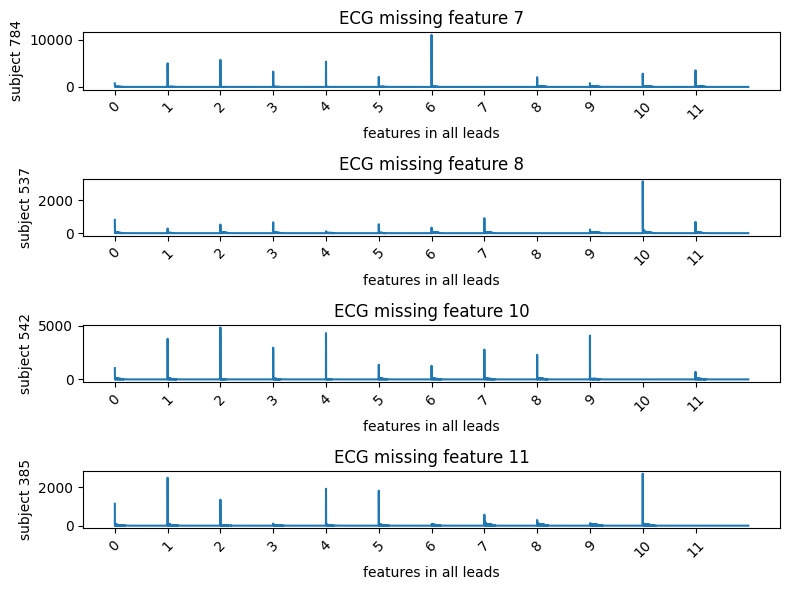

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(4, 1, figsize=(8, 6))

sns.lineplot(x = data.columns,y=data.iloc[784,:],ax = axes[0])
sns.lineplot(x = data.columns,y=data.iloc[537,:],ax = axes[1])
sns.lineplot(x = data.columns,y=data.iloc[542,:],ax = axes[2])
sns.lineplot(x = data.columns,y=data.iloc[385,:],ax = axes[3])


axes[0].set_xticks(np.arange(0,9000, 750), labels=['0', '1', '2', '3', '4', '5','6','7','8','9','10','11'],rotation = 45)
axes[1].set_xticks(np.arange(0,9000, 750), labels=['0', '1', '2', '3', '4', '5','6','7','8','9','10','11'],rotation = 45)
axes[2].set_xticks(np.arange(0,9000, 750), labels=['0', '1', '2', '3', '4', '5','6','7','8','9','10','11'],rotation = 45)
axes[3].set_xticks(np.arange(0,9000, 750), labels=['0', '1', '2', '3', '4', '5','6','7','8','9','10','11'],rotation = 45)

axes[0].set(ylabel = 'subject 784',
            xlabel = 'features in all leads',
            title = 'ECG missing feature 7')
axes[1].set(ylabel = 'subject 537',
            xlabel = 'features in all leads',
            title = 'ECG missing feature 8')
axes[2].set(ylabel = 'subject 542',
            xlabel = 'features in all leads',
            title = 'ECG missing feature 10')
axes[3].set(ylabel = 'subject 385',
            xlabel = 'features in all leads',
            title = 'ECG missing feature 11')

plt.tight_layout()

plt.show()


Based on these figures we can conclude that for some patients no ECG was recorded in certain leads. Although no features are present in these leads we choose to retain these samples as information other leads may be sufficient to make a classification.

However, users of this model should identify if leads are missing in the original data. **An assumption of the input data in our model is that at least 11 of the 12 leads must be present.**

In [110]:
print('Number of missing values:',data.isna().sum(1).sum())

Number of missing values: 0


There are no missing values present. **An assumption of the input data in our model is that missing values should be handled in a appropriate manner depending on the frequency/distribution of the missing values.**

In [51]:
# Verhoudingen van de groepen
import matplotlib.pyplot as plt
text = ['normaal','afwijkend']
lst_labels = list(labels)
frequentie = [lst_labels.count(0), lst_labels.count(1)]
plt.bar(text, frequentie)
plt.title('Frequentie van een normaal en afwijkend hartritme')
plt.ylabel('Aantal')
plt.show()

NameError: name 'labels' is not defined

In [ ]:
# Voorbeeld van een eerste plotje
import matplotlib.pyplot as plt

feature_1 = '0_0'
feature_2 = '11_742'
scatter = plt.scatter(feature_data[feature_1],feature_data[feature_2], c = labels)
plt.title('Een voorbeeld van twee features tegen elkaar uitgezet')
plt.xlabel(feature_1)
plt.ylabel(feature_2)
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="Klasses")
plt.show()

We kunnen een scatter maken. De waarden lopen heel erg uiteen. Scaling is dus belangrijk

In [ ]:
# Testen per feature of het normaal verdeeld is per groep
from scipy.stats import shapiro

data_gezond = data[data["label"] == 0]
data_afwijkend = data[data["label"] == 1]

data_gezond = data_gezond.drop('label',axis = 1)
data_afwijkend = data_afwijkend.drop('label',axis = 1)

niet_nrml_vd_gezond = dict()
for kolomnaam in data_gezond.columns:
  statistiek = shapiro(list(data_gezond[kolomnaam]))
  if statistiek[1] > 0.05:
    niet_nrml_vd_gezond[kolomnaam] = statistiek[1]
print(niet_nrml_vd_gezond)

niet_nrml_vd_afwijkend = dict()
for kolomnaam in data_afwijkend.columns:
  statistiek = shapiro(list(data_afwijkend[kolomnaam]))
  if statistiek[1] > 0.05:
    niet_nrml_vd_afwijkend[kolomnaam] = statistiek[1]
print(niet_nrml_vd_afwijkend)



conclusie: Aan de hand van een shapiro test met een p-waarde van 0.05 is gebleken dat alle features normaal verdeeld zijn.

## Soorteren op meest significant verschillend
Hieronder wordt een tweezijdige T-test gedaan voor de data. Er wordt gekeken of er een significant verschil is tussen de gezond of ongezond groep per feature. De meest significant verschillende features worden vervolgens gebruikt om een pairplot te maken

In [ ]:
from scipy.stats import ttest_ind
import numpy as np
p_values = ttest_ind(a=data_gezond, b=data_afwijkend, axis = 0, equal_var=False)

dict_p_values = dict()
for kolom in data_gezond.columns:
  p_value = ttest_ind(data_gezond[kolom],data_afwijkend[kolom],equal_var=False)
  dict_p_values[kolom] = p_value[1]

print(dict_p_values)
dict_sorted_p_values = dict(sorted(dict_p_values.items(),key = lambda x:x[1]))
print(dict_sorted_p_values)
features_sorted = list(dict_sorted_p_values.keys())
# sort_ind = np.argsort(p_values[1])
# print(sort_ind)
# print(np.array(p_values[1]))

In [ ]:
import seaborn as sns
most_sign_data = data[features_sorted[:4] + ["label"]]
sns.pairplot(data = most_sign_data,hue = "label")